# Import Libraries #

In [44]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import cv2 #images
from PIL import Image

import tensorflow 
from tensorflow import keras
from keras.models import Model, Sequential, load_model
from keras import layers, regularizers, utils

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## import dependencies for model
from tensorflow.keras.layers import *
from tensorflow.keras.utils import *
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

from sklearn.metrics import classification_report, confusion_matrix

# Prepare the Data #

In [3]:
df = pd.read_csv('data/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
df_clean = df.drop(columns=["dx_type", "age", "sex", "localization", "lesion_id"])
df_clean.rename(columns={'dx': 'label'}, inplace=True)
df_clean.head()

,image_id,label
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl
2,ISIC_0026769,bkl
3,ISIC_0025661,bkl
4,ISIC_0031633,bkl


In [5]:
# # replace shortened names with full names

df_clean.replace({'label': {'bkl': 'Benign'}}, inplace=True)
df_clean.replace({'label': {'nv': 'Benign'}}, inplace=True)
df_clean.replace({'label': {'mel': 'Malignant'}}, inplace=True)
df_clean.replace({'label': {'bcc': 'Malignant'}}, inplace=True)
df_clean.replace({'label': {'akiec': 'Benign'}}, inplace=True)
df_clean.replace({'label': {'df': 'Benign'}}, inplace=True)
df_clean.replace({'label': {'vasc': 'Benign'}}, inplace=True)

df_clean.head()

,image_id,label
0,ISIC_0027419,Benign
1,ISIC_0025030,Benign
2,ISIC_0026769,Benign
3,ISIC_0025661,Benign
4,ISIC_0031633,Benign


In [6]:
df_clean["label"].value_counts() # Check if data is imbalanced

label
Benign       8388
Malignant    1627
Name: count, dtype: int64

In [7]:
import glob
import os
from PIL import Image


def create_image_dict():
    # Use glob to find all image files in the folder
    image_paths = glob.glob(('/Users/sarahdutton/Desktop/HAM trial folder/images_1/*.jpg'), recursive=True) 

    image_dict = {}
    for image_path in image_paths:
        # Extract the filename
        filename = os.path.basename(image_path)
        # Open and load the image
        image = Image.open(image_path)
        # Store in the dictionary
        image_dict[filename] = image
        image.close()
    return image_dict

# Example usage

images = create_image_dict()



In [8]:
df_clean.head()

,image_id,label
0,ISIC_0027419,Benign
1,ISIC_0025030,Benign
2,ISIC_0026769,Benign
3,ISIC_0025661,Benign
4,ISIC_0031633,Benign


In [9]:
df_clean['file_name'] = images.keys()
df_clean['cell_type_idx'] = pd.Categorical(df_clean['label']).codes
df_clean.head()

,image_id,label,file_name,cell_type_idx
0,ISIC_0027419,Benign,ISIC_0030858.jpg,0
1,ISIC_0025030,Benign,ISIC_0030680.jpg,0
2,ISIC_0026769,Benign,ISIC_0033389.jpg,0
3,ISIC_0025661,Benign,ISIC_0032097.jpg,0
4,ISIC_0031633,Benign,ISIC_0032929.jpg,0


In [10]:
base_path = '/Users/sarahdutton/Desktop/HAM trial folder/images_1/' 
df_clean['full_path'] = base_path + df_clean['file_name']
df_clean.head()

,image_id,label,file_name,cell_type_idx,full_path
0,ISIC_0027419,Benign,ISIC_0030858.jpg,0,/Users/sarahdutton/Desktop/HAM trial folder/im...
1,ISIC_0025030,Benign,ISIC_0030680.jpg,0,/Users/sarahdutton/Desktop/HAM trial folder/im...
2,ISIC_0026769,Benign,ISIC_0033389.jpg,0,/Users/sarahdutton/Desktop/HAM trial folder/im...
3,ISIC_0025661,Benign,ISIC_0032097.jpg,0,/Users/sarahdutton/Desktop/HAM trial folder/im...
4,ISIC_0031633,Benign,ISIC_0032929.jpg,0,/Users/sarahdutton/Desktop/HAM trial folder/im...


In [11]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
images = []
for path in df_clean['full_path']:
    img = load_img(path, target_size=(224, 224))  # Adjust size as necessary
    x = img_to_array(img)
    images.append(x)

In [12]:
images_array = np.array(images)
images_array

array([[[[ 30.,  23.,  31.],
         [ 28.,  22.,  24.],
         [ 34.,  25.,  28.],
         ...,
         [ 56.,  44.,  46.],
         [ 62.,  46.,  49.],
         [ 63.,  47.,  50.]],

        [[ 31.,  25.,  25.],
         [ 32.,  23.,  26.],
         [ 31.,  22.,  23.],
         ...,
         [ 62.,  46.,  49.],
         [ 61.,  45.,  46.],
         [ 61.,  45.,  45.]],

        [[ 31.,  22.,  25.],
         [ 30.,  22.,  20.],
         [ 33.,  25.,  22.],
         ...,
         [ 58.,  42.,  45.],
         [ 60.,  44.,  47.],
         [ 61.,  45.,  48.]],

        ...,

        [[ 54.,  41.,  50.],
         [ 54.,  38.,  49.],
         [ 49.,  35.,  48.],
         ...,
         [ 33.,  20.,  29.],
         [ 31.,  20.,  24.],
         [ 29.,  20.,  23.]],

        [[ 58.,  41.,  51.],
         [ 52.,  38.,  51.],
         [ 51.,  39.,  51.],
         ...,
         [ 31.,  22.,  27.],
         [ 28.,  19.,  22.],
         [ 31.,  20.,  26.]],

        [[ 56.,  43.,  53.],
       

In [13]:
df_clean.head()

,image_id,label,file_name,cell_type_idx,full_path
0,ISIC_0027419,Benign,ISIC_0030858.jpg,0,/Users/sarahdutton/Desktop/HAM trial folder/im...
1,ISIC_0025030,Benign,ISIC_0030680.jpg,0,/Users/sarahdutton/Desktop/HAM trial folder/im...
2,ISIC_0026769,Benign,ISIC_0033389.jpg,0,/Users/sarahdutton/Desktop/HAM trial folder/im...
3,ISIC_0025661,Benign,ISIC_0032097.jpg,0,/Users/sarahdutton/Desktop/HAM trial folder/im...
4,ISIC_0031633,Benign,ISIC_0032929.jpg,0,/Users/sarahdutton/Desktop/HAM trial folder/im...


In [14]:
df_clean['image'] = df_clean['full_path'].map(lambda x: np.asarray(Image.open(x).resize((224,224)))) # did i just do this three times?

In [15]:
df_clean['image'].map(lambda x: x.shape).value_counts() #checking image size dist

image
(224, 224, 3)    10015
Name: count, dtype: int64

In [16]:
# testing to open one image -- it works!

# testing = Image.open('../HAM trial folder/images_1/ISIC_0024306.jpg')
# testing.show()

In [17]:
# df_clean.head()

In [18]:
# Split the DataSet
from sklearn.model_selection import train_test_split

features = df_clean.drop(columns=['cell_type_idx', 'image_id'],axis=1)
target = df_clean['cell_type_idx']

In [19]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

In [20]:
# convert data to categorical types
x = x.astype('float32') / 255.0
y = np.array(df_clean['cell_type_idx'])

y_train = to_categorical(y_train_o, num_classes=2)
y_test = to_categorical(y_test_o, num_classes=2)

In [21]:
# normalize data

x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std


In [22]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(8012, 224, 224, 3)
(8012, 2)
(2003, 224, 224, 3)
(2003, 2)


# Build CNN Architecture #

In [24]:
# Build CNN (conv neural network) Model
input_shape = (224, 224, 3)
num_classes = 2

model = Sequential()

    # Block 1
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
model.add(BatchNormalization())

    # Block 2
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
model.add(BatchNormalization())

    # Block 3
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
model.add(BatchNormalization())

    # Block 4
model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
model.add(BatchNormalization())

    # Block 5
model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
model.add(BatchNormalization())

# Flatten and Fully Connected Layers
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))


/opt/anaconda3/envs/dev/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Compile the Model #

In [25]:
model.compile(optimizer='adam',loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 512)      │         2,04

 Total params: 134,274,626 (512.22 MB)

 Trainable params: 134,271,682 (512.21 MB)

 Non-trainable params: 2,944 (11.50 KB)

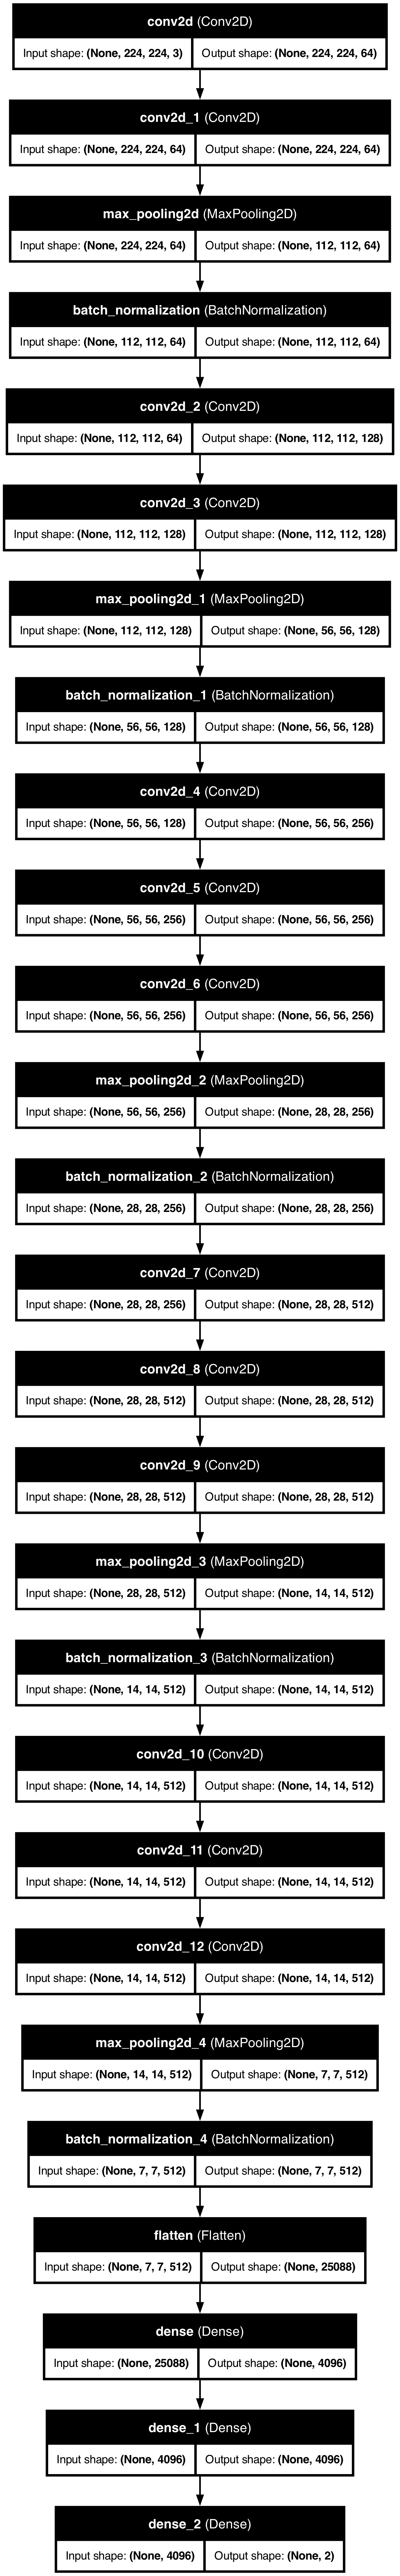

In [51]:
# # # plot the model 
from keras.utils import plot_model

tensorflow.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

# Train the Model #

In [52]:
# Fit (train) the model
history = model.fit(
    x_train,
    y_train,
    epochs=50,
    shuffle=True,
    verbose=2
)

Epoch 1/50
251/251 - 1574s - 6s/step - accuracy: 0.8371 - loss: 0.4867
Epoch 2/50
251/251 - 1485s - 6s/step - accuracy: 0.8397 - loss: 0.4631
Epoch 3/50
251/251 - 1484s - 6s/step - accuracy: 0.8397 - loss: 0.4510
Epoch 4/50
251/251 - 1494s - 6s/step - accuracy: 0.8397 - loss: 0.4462
Epoch 5/50
251/251 - 1485s - 6s/step - accuracy: 0.8397 - loss: 0.4447
Epoch 6/50
251/251 - 1442s - 6s/step - accuracy: 0.8397 - loss: 0.4446
Epoch 7/50
251/251 - 1414s - 6s/step - accuracy: 0.8397 - loss: 0.4435
Epoch 8/50
251/251 - 1435s - 6s/step - accuracy: 0.8397 - loss: 0.4456
Epoch 9/50
251/251 - 1430s - 6s/step - accuracy: 0.8397 - loss: 0.4430
Epoch 10/50
251/251 - 1437s - 6s/step - accuracy: 0.8397 - loss: 0.4414
Epoch 11/50
251/251 - 1476s - 6s/step - accuracy: 0.8397 - loss: 0.4417
Epoch 12/50
251/251 - 1467s - 6s/step - accuracy: 0.8389 - loss: 0.4530
Epoch 13/50
251/251 - 1441s - 6s/step - accuracy: 0.8394 - loss: 0.4539
Epoch 14/50
251/251 - 1456s - 6s/step - accuracy: 0.8395 - loss: 0.4454
E

# Evaluate the Model #

In [ ]:
# PREVENT OVERFITTING
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [ ]:
# # Evaluate the model using the training data 
model_loss, model_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

In [ ]:
train_score = model.evaluate(x_train, y_train, verbose= 1)
test_score = model.evaluate(x_test, y_test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

# Save the Model #

In [53]:
model.save('cnnModel.h5')